In [1]:
import os
import pandas as pd
import numpy as np
import shutil
import sys
import tqdm.notebook as tq
from collections import defaultdict

import torch
import torch.nn as nn

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [2]:
df_data = pd.read_csv('multi_label_binarizer_MEISD.csv')

In [3]:
#df_data = df_data.loc[df_data.iloc[:,2:].apply(sum, axis=1) == 1,:].sample(n = 10_000, random_state = 4)
df_data = df_data.sample(n = 10_000, random_state = 4)

In [4]:
df_data

,Utterances,sentiment_0,sentiment_1,sentiment_2,emotion_1,emotion_2,emotion_3,emotion_4,emotion_5,emotion_6,emotion_7,emotion_8,emotion_9,intensity_1,intensity_2,intensity_3
2712,that's not all that was long,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0
18590,or does somebody miss me?,0,0,1,0,0,0,1,0,0,0,1,0,1,1,0
19697,"why holly and i should be together,",0,1,0,0,0,1,0,1,0,0,0,0,1,1,0
16157,i'm sorry. i didn't mean for that to come off,0,0,1,0,0,1,1,0,0,0,0,0,1,1,0
11635,"things got a little slow, so we made some wagers",1,0,0,0,0,0,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13533,how's her driving? driving. is she good behind...,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0
15237,No-no-no. I don't have a son named Jordie. We ...,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1
10261,just because you got out of clinic duty doesn'...,1,0,0,0,0,1,0,0,0,1,0,0,1,1,0
11528,yeah. your mother told me,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0


In [5]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df_data, random_state=77, test_size=0.30, shuffle=True)
df_test, df_valid = train_test_split(df_test, random_state=88, test_size=0.50, shuffle=True)

In [6]:
print(f"Train: {df_train.shape}, Test: {df_test.shape}, Valid: {df_valid.shape}")

Train: (7000, 16), Test: (1500, 16), Valid: (1500, 16)


In [7]:
# Check data types
print(df_data.dtypes)

Utterances     object
sentiment_0     int64
sentiment_1     int64
sentiment_2     int64
emotion_1       int64
emotion_2       int64
emotion_3       int64
emotion_4       int64
emotion_5       int64
emotion_6       int64
emotion_7       int64
emotion_8       int64
emotion_9       int64
intensity_1     int64
intensity_2     int64
intensity_3     int64
dtype: object


In [8]:
# Hyperparameters
MAX_LEN = 256
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 32
TEST_BATCH_SIZE = 32
EPOCHS = 3
LEARNING_RATE = 1e-05

In [9]:
from transformers import BertTokenizer, BertModel
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

D:\conda\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [10]:
# Test the tokenizer
test_text = "We are testing BERT tokenizer."
# generate encodings
encodings = tokenizer.encode_plus(test_text,
                                  add_special_tokens = True,
                                  max_length = 50,
                                  truncation = True,
                                  padding = "max_length",
                                  return_attention_mask = True,
                                  return_tensors = "pt")
# we get a dictionary with three keys (see: https://huggingface.co/transformers/glossary.html) 
encodings

{'input_ids': tensor([[  101,  2057,  2024,  5604, 14324, 19204, 17629,  1012,   102,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0]])}

In [11]:
df_train['Utterances']

15443                       I thought there wasn't a ball?
13052                        what are you waiting for? go!
4143                             this one time, she was at
7275              while the victor still licks his wounds.
16153    you've begged me to move you up, and now suddenly
                               ...                        
9360     anyway, i told you already, i'm taking a break...
1232     you know what? you sound more and more like mo...
2426                                      at the same time
1237        did you say "ham"? - you're either ham or eggs
6362     Every man who has tasted my cooking has told m...
Name: Utterances, Length: 7000, dtype: object

In [12]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, df, tokenizer, max_len, target_list):
        self.tokenizer = tokenizer
        self.df = df
        self.title = list(df['Utterances'])
        self.targets = self.df[target_list].values
        self.max_len = max_len

    def __len__(self):
        return len(self.title)

    def __getitem__(self, index):
        title = str(self.title[index])
        title = " ".join(title.split())
        inputs = self.tokenizer.encode_plus(
            title,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'token_type_ids': inputs["token_type_ids"].flatten(),
            # Ensure the correct type here
            'targets': torch.FloatTensor(self.targets[index]),
            #'targets': torch.tensor(self.targets[index], dtype=torch.float32),  
            'title': title
        }


In [13]:
target_list = list(df_data.columns)
target_list

['Utterances',
 'sentiment_0',
 'sentiment_1',
 'sentiment_2',
 'emotion_1',
 'emotion_2',
 'emotion_3',
 'emotion_4',
 'emotion_5',
 'emotion_6',
 'emotion_7',
 'emotion_8',
 'emotion_9',
 'intensity_1',
 'intensity_2',
 'intensity_3']

In [14]:
target_list = target_list[1:]
target_list

['sentiment_0',
 'sentiment_1',
 'sentiment_2',
 'emotion_1',
 'emotion_2',
 'emotion_3',
 'emotion_4',
 'emotion_5',
 'emotion_6',
 'emotion_7',
 'emotion_8',
 'emotion_9',
 'intensity_1',
 'intensity_2',
 'intensity_3']

In [15]:
print(df_train[target_list].dtypes)

sentiment_0    int64
sentiment_1    int64
sentiment_2    int64
emotion_1      int64
emotion_2      int64
emotion_3      int64
emotion_4      int64
emotion_5      int64
emotion_6      int64
emotion_7      int64
emotion_8      int64
emotion_9      int64
intensity_1    int64
intensity_2    int64
intensity_3    int64
dtype: object


In [16]:
train_dataset = CustomDataset(df_train, tokenizer, MAX_LEN, target_list)
valid_dataset = CustomDataset(df_valid, tokenizer, MAX_LEN, target_list)
test_dataset = CustomDataset(df_test, tokenizer, MAX_LEN, target_list)

In [17]:
# Data loaders
train_data_loader = torch.utils.data.DataLoader(train_dataset,
                                                batch_size=TRAIN_BATCH_SIZE,
                                                shuffle=True,
                                                num_workers=0
                                                )

val_data_loader = torch.utils.data.DataLoader(valid_dataset,
                                              batch_size=VALID_BATCH_SIZE,
                                              shuffle=False,
                                              num_workers=0
                                              )

test_data_loader = torch.utils.data.DataLoader(test_dataset,
                                               batch_size=TEST_BATCH_SIZE,
                                               shuffle=False,
                                               num_workers=0
                                               )

In [18]:
class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.bert_model = BertModel.from_pretrained('bert-base-uncased', return_dict=True)
        self.dropout = torch.nn.Dropout(0.3)
        self.linear = torch.nn.Linear(768, 15) #number of classes

    def forward(self, input_ids, attn_mask, token_type_ids):
        output = self.bert_model(
            input_ids,
            attention_mask=attn_mask,
            token_type_ids=token_type_ids
        )
        output_dropout = self.dropout(output.pooler_output)
        output = self.linear(output_dropout)
        output = torch.sigmoid(output)  # Zastosowanie funkcji Sigmoid
        return output

model = BERTClass()

# # Freezing BERT layers: (tested, weaker convergence)
# for param in model.bert_model.parameters():
#     param.requires_grad = False

model.to(device)


BERTClass(
  (bert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwi

In [19]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

In [20]:
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-5)         


D:\conda\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [21]:
# Training of the model for one epoch
def train_model(training_loader, model, optimizer):

    losses = []
    correct_predictions = 0
    num_samples = 0
    # set model to training mode (activate droput, batch norm)
    model.train()
    # initialize the progress bar
    loop = tq.tqdm(enumerate(training_loader), total=len(training_loader),
                   leave=True, colour='steelblue')
    for batch_idx, data in loop:
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

# forward
        outputs = model(ids, mask, token_type_ids) # (batch,predict)=(32,8)
        loss = loss_fn(outputs, targets)
        losses.append(loss.item())
        # training accuracy
        _, preds = torch.max(outputs, dim=1) # batch dim 
        _, targ = torch.max(targets, dim=1)  # batch dim
        num_samples += len(targ)  # technically adding batch size
        correct_predictions += torch.sum(preds == targ)

        # backward
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        # grad descent step
        optimizer.step()

        # Update progress bar
        #loop.set_description(f"")
        #loop.set_postfix(batch_loss=loss)

    # returning: trained model, model accuracy, mean loss
    return model, float(correct_predictions)/num_samples, np.mean(losses)


In [22]:
def eval_model(validation_loader, model, optimizer):
    losses = []
    correct_predictions = 0
    num_samples = 0
    # set model to eval mode (turn off dropout, fix batch norm)
    model.eval()

    with torch.no_grad():
        for batch_idx, data in enumerate(validation_loader, 0):
            ids = data['input_ids'].to(device, dtype = torch.long)
            mask = data['attention_mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)

            loss = loss_fn(outputs, targets)
            losses.append(loss.item())

            # validation accuracy
            _, preds = torch.max(outputs, dim=1) # batch dim 
            _, targ = torch.max(targets, dim=1)  # batch dim
            num_samples += len(targ)  # technically adding batch size
            correct_predictions += torch.sum(preds == targ)

    return float(correct_predictions)/num_samples, np.mean(losses)
     


In [23]:
history = defaultdict(list)
best_accuracy = 0

for epoch in range(1, EPOCHS+1):
    print(f'Epoch {epoch}/{EPOCHS}')
    model, train_acc, train_loss = train_model(train_data_loader, model, optimizer)
    val_acc, val_loss = eval_model(val_data_loader, model, optimizer)

    print(f'train_loss={train_loss:.4f}, val_loss={val_loss:.4f} train_acc={train_acc:.4f}, val_acc={val_acc:.4f}')

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    # save the best model
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), "best_model_state.bin")
        best_accuracy = val_acc


Epoch 1/3


  0%|          | 0/219 [00:00<?, ?it/s]

train_loss=0.7634, val_loss=0.7149 train_acc=0.2230, val_acc=0.5960
Epoch 2/3


  0%|          | 0/219 [00:00<?, ?it/s]

train_loss=0.7066, val_loss=0.7001 train_acc=0.5859, val_acc=0.5960
Epoch 3/3


  0%|          | 0/219 [00:00<?, ?it/s]

train_loss=0.6986, val_loss=0.6966 train_acc=0.5959, val_acc=0.5960


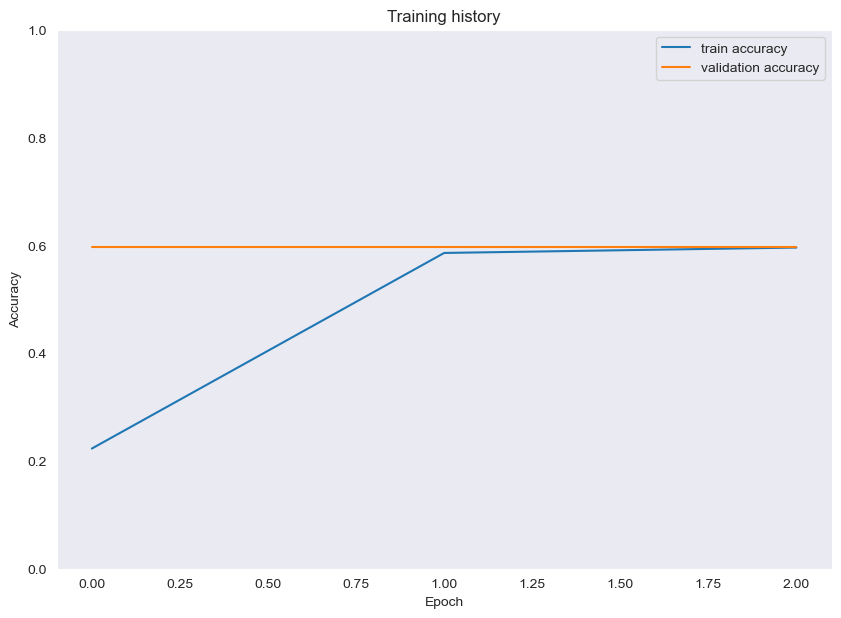

In [24]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,7)
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])
plt.grid()

In [25]:
# Loading pretrained model
model = BERTClass()
model.load_state_dict(torch.load('best_model_state.bin'))
model = model.to(device)

In [26]:
# Evaluate the model using the test data
test_acc, test_loss = eval_model(test_data_loader, model, optimizer)

In [27]:
# The accuracy looks OK, similar to the validation accuracy
# The model generalizes well !
test_acc

0.5653333333333334

In [28]:
from sklearn.metrics import confusion_matrix, classification_report
def get_predictions(model, data_loader):
    model = model.eval()

    titles = []
    predictions = []
    prediction_probs = []
    target_values = []

    with torch.no_grad():
        for data in data_loader:
            title = data["title"]
            ids = data["input_ids"].to(device, dtype = torch.long)
            mask = data["attention_mask"].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data["targets"].to(device, dtype = torch.float)

            outputs = model(ids, mask, token_type_ids)
            _, preds = torch.max(outputs, dim=1)
            _, targ = torch.max(targets, dim=1)

            titles.extend(title)
            predictions.extend(preds)
            prediction_probs.extend(outputs)
            target_values.extend(targ)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    target_values = torch.stack(target_values).cpu()

    return titles, predictions, prediction_probs, target_values

In [29]:
titles, predictions, prediction_probs, target_values = get_predictions(model, test_data_loader)


In [30]:
#target_list = list(df_data.columns)
#target_list = target_list[2:]
#target_list = [col for col in target_list if col not in ['start_times', 'end_times']]
#target_list

In [31]:
print(f"Unique classes in predictions: {torch.unique(predictions)}")
print(f"Unique classes in target values: {torch.unique(target_values)}")
print(f"Unique classes in target_list: {target_list}")

Unique classes in predictions: tensor([2])
Unique classes in target values: tensor([0, 1, 2])
Unique classes in target_list: ['sentiment_0', 'sentiment_1', 'sentiment_2', 'emotion_1', 'emotion_2', 'emotion_3', 'emotion_4', 'emotion_5', 'emotion_6', 'emotion_7', 'emotion_8', 'emotion_9', 'intensity_1', 'intensity_2', 'intensity_3']


In [32]:
from collections import Counter

# Check the distribution of target classes
target_distribution = Counter(target_values.numpy())
print(f"Target class distribution: {target_distribution}")


Target class distribution: Counter({2: 848, 1: 358, 0: 294})


In [34]:
#target_list = ['Class 1', 'Class 3', 'Class 5']  # Replace with your actual class names
target_list = ['Class 0', 'Class 1', 'Class 2']

In [35]:
# Classification report
print(classification_report(target_values, predictions, target_names=target_list))


              precision    recall  f1-score   support

     Class 0       0.00      0.00      0.00       294
     Class 1       0.00      0.00      0.00       358
     Class 2       0.57      1.00      0.72       848

    accuracy                           0.57      1500
   macro avg       0.19      0.33      0.24      1500
weighted avg       0.32      0.57      0.41      1500


D:\conda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\conda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\conda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [36]:
import seaborn as sns
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True category')
    plt.xlabel('Predicted category');

In [42]:
# raw text
raw_text = "is this the only reason you are calling, jan?"


In [43]:
encoded_text = tokenizer.encode_plus(
    raw_text,
    max_length=MAX_LEN,
    add_special_tokens=True,
    return_token_type_ids=True,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_tensors='pt',
)


D:\conda\Lib\site-packages\transformers\tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [44]:
input_ids = encoded_text['input_ids'].to(device)
attention_mask = encoded_text['attention_mask'].to(device)
token_type_ids = encoded_text['token_type_ids'].to(device)
output = model(input_ids, attention_mask, token_type_ids)
_, prediction = torch.max(output, dim=1)


In [46]:
# Correctly predicted the topic of the paper: High energy physics 
print(f'Dialogue: {raw_text}')
print(f'Category: {target_list[prediction]}')


Dialogue: is this the only reason you are calling, jan?
Category: Class 2


In [47]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
labels = ['Class 1', 'Class 3', 'Class 5'] 
cm = confusion_matrix(target_values, predictions, labels=labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=target_list, yticklabels=target_list)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

ValueError: At least one label specified must be in y_true